<a href="https://colab.research.google.com/github/shreya0505/BTP_7thSem/blob/main/VAE_MNIST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist, fashion_mnist

In [88]:
np.random.seed(25)
tf.executing_eagerly()

False

In [89]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [90]:
# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()



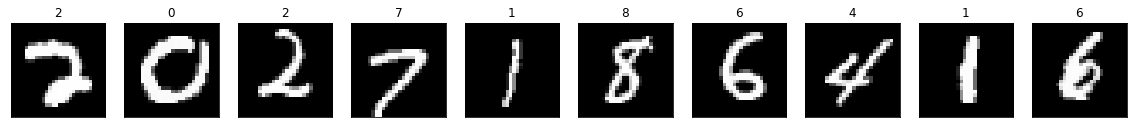

In [91]:
# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Displaying 120th to 129th data
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

In [92]:
# Normalize values such that all numbers are within
# the range of 0 to 1

X_train = X_train/255
X_test = X_test/255

In [93]:
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print("Previous:")
print(X_train.shape)
print(X_test.shape)
print("Current:")
print(X_train_new.shape)
print(X_test_new.shape)

Previous:
(60000, 28, 28)
(10000, 28, 28)
Current:
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [94]:
# Defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space

In [95]:
# Constructing encoder
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [96]:
# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps


In [97]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])


In [98]:
# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)
print(conv_shape)

(None, 14, 14, 16)


In [99]:
# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

In [100]:
# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

In [101]:
print(encoder.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 16)   160         ['input_5[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                                  
 dense_6 (Dense)                (None, 2)            6274        ['flatten_2[0][0]']              
                                                                                            

In [102]:
print(decoder.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 14, 14, 16)        0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 8)        1160      
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 1)        73        
 ranspose)                                                       
                                                                 
Total params: 10,641
Trainable params: 10,641
Non-trainable

In [103]:
print(vae.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_7 (Functional)        (None, 2)                 12708     
                                                                 
 model_8 (Functional)        (None, 28, 28, 1)         10641     
                                                                 
Total params: 23,349
Trainable params: 23,349
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [105]:
# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [106]:
# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=20, batch_size=32, validation_data=(X_test_new,X_test_new))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
59936/60000 [============================>.] - ETA: 0s - loss: 187.0525

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 38s 642us/sample - loss: 187.0385 - val_loss: 172.5396
Epoch 2/20
60000/60000 [==============================] - 38s 631us/sample - loss: 170.7576 - val_loss: 168.5738
Epoch 3/20
60000/60000 [==============================] - 38s 628us/sample - loss: 167.2358 - val_loss: 166.1346
Epoch 4/20
60000/60000 [==============================] - 38s 627us/sample - loss: 165.4770 - val_loss: 164.6378
Epoch 5/20
60000/60000 [==============================] - 38s 627us/sample - loss: 164.4376 - val_loss: 163.9869
Epoch 6/20
60000/60000 [==============================] - 38s 627us/sample - loss: 163.7632 - val_loss: 163.3997
Epoch 7/20
60000/60000 [==============================] - 38s 628us/sample - loss: 163.2400 - val_loss: 162.8694
Epoch 8/20
60000/60000 [==============================] - 37s 625us/sample - loss: 162.8520 - val_loss: 162.7294
Epoch 9/20
60000/60000 [==============================] - 37s 624us/sample - loss: 162.5410 - val_loss: 162

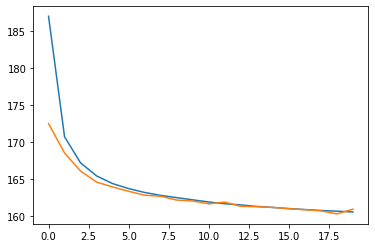

In [107]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [108]:
# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [138]:
encoded_test = encoder.predict(X_test_new)

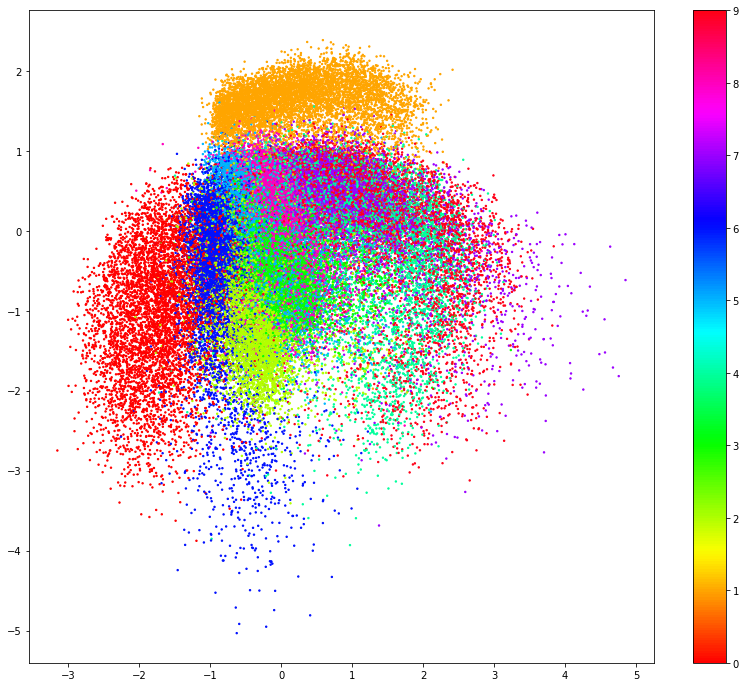

In [109]:
# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()

In [119]:
new_encoder = Model(encoder_input, latent_space)

In [121]:
print(new_encoder.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 16)   160         ['input_5[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                                  
 dense_6 (Dense)                (None, 2)            6274        ['flatten_2[0][0]']              
                                                                                           

In [128]:
new_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=kl_reconstruction_loss)

In [140]:
enocoder_history = new_encoder.fit(x=X_train_new, y= encoded, epochs=20, batch_size=32, validation_data=(X_test_new, encoded_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 136us/sample - loss: -10630.2681 - val_loss: 15522.4773
Epoch 2/20
60000/60000 [==============================] - 8s 130us/sample - loss: -11157.4374 - val_loss: 15342.4175
Epoch 3/20
60000/60000 [==============================] - 8s 127us/sample - loss: -11188.9677 - val_loss: 15825.8215
Epoch 4/20
60000/60000 [==============================] - 8s 130us/sample - loss: -11051.0717 - val_loss: 16122.2981
Epoch 5/20
60000/60000 [==============================] - 8s 134us/sample - loss: -11145.8599 - val_loss: 14944.3956
Epoch 6/20
60000/60000 [==============================] - 8s 130us/sample - loss: -11246.4762 - val_loss: 15611.2589
Epoch 7/20
60000/60000 [==============================] - 8s 127us/sample - loss: -11264.9548 - val_loss: 15524.5779
Epoch 8/20
60000/60000 [==============================] - 8s 127us/sample - loss: -11231.5180 - val_loss: 14707.3621
Epoch 9/20
600

In [145]:
encoded_testing = new_encoder.predict(X_test_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


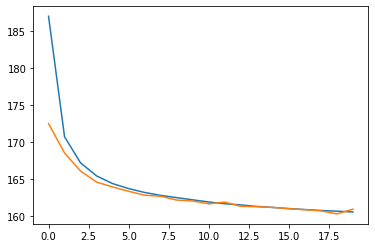

In [141]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

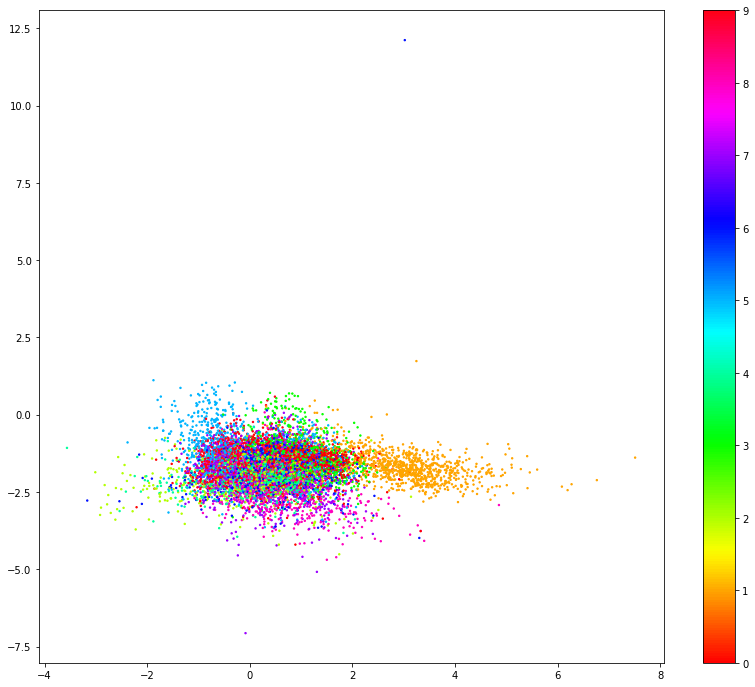

In [148]:
# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded_testing[:,0], encoded_testing[:,1], s=2, c=y_test,cmap='hsv')
plt.colorbar()